In [1]:
import os
from pathlib import Path

project_root = Path.cwd().parent.parent
os.chdir(project_root)
print(os.getcwd())

/homes/dwiersma/Desktop/internship


# Using the best model

In [2]:
import pickle as pkl
import tomllib

from src.ml.cforest import Cforest
from src.data import Data

# load config
with open("config.toml", "rb") as file:
    config = tomllib.load(file)

# load the microarray data (set in config.toml), not important here though
data = Data(config)

data.replace_sample_sep(".")

ma_data = data.get_mm_with_tt()
ma_data.columns = ma_data.columns.str.replace(" ", "_")
print(f"ma_data shape: {ma_data.shape}")

2024-01-16 12:35:55,757:src.log_manager:INFO:Loading data...
2024-01-16 12:36:46,037:src.log_manager:INFO:Data loaded in 50.2768 seconds


ma_data shape: (15403, 9710)


In [3]:
import pandas as pd

ma_data = pd.read_csv("data/subsets_sorted/ma_15ct_min100s.csv")

ma_data = ma_data.set_index("samples")

ma_data.columns = ma_data.columns.str.replace(" ", "_")

ma_data

,response,consensus_independent_component_1,consensus_independent_component_2,consensus_independent_component_3,consensus_independent_component_4,consensus_independent_component_5,consensus_independent_component_6,consensus_independent_component_7,consensus_independent_component_8,consensus_independent_component_9,...,consensus_independent_component_9700,consensus_independent_component_9701,consensus_independent_component_9702,consensus_independent_component_9703,consensus_independent_component_9704,consensus_independent_component_9705,consensus_independent_component_9706,consensus_independent_component_9707,consensus_independent_component_9708,consensus_independent_component_9709
samples,,,,,,,,,,,,,,,,,,,,,
GSM1001610_1025A.CEL,Lung adenocarcinoma,0.495375,-0.144994,0.653698,0.152382,0.974743,-1.710693,-0.674743,-1.001575,-0.442906,...,2.016707,-1.916875,-0.279630,0.600953,1.377651,-1.128128,-1.328154,0.578141,-1.893471,-2.856941
GSM1001611_104A.CEL,Lung adenocarcinoma,0.799637,-0.921576,0.656700,1.470572,1.217788,-1.019460,0.245733,0.728797,0.139614,...,1.226005,-0.073671,0.027042,-0.909825,1.956098,-1.654324,0.053610,0.531980,-1.408957,0.909090
GSM1001612_1065A.CEL,Lung adenocarcinoma,0.366373,-0.482790,0.621760,1.370997,1.656947,-1.713003,-1.194420,-1.965064,0.229646,...,0.187451,-0.977721,-1.352886,1.456342,2.723599,-0.453462,-0.812171,-0.865397,-1.558949,0.173424
GSM1001613_1176B.CEL,Lung adenocarcinoma,1.411042,-0.726494,-0.918696,0.294711,0.930908,-0.738137,-1.737150,-0.502270,-0.324505,...,0.974812,-1.271406,0.718995,-0.761002,2.387306,-0.167512,-0.595910,0.561011,-0.863321,2.545537
GSM1001614_1179A.CEL,Lung adenocarcinoma,-0.856902,-0.739656,-0.404778,0.858474,0.329020,-0.785700,-0.822693,2.452808,-0.408857,...,1.263094,-1.985830,0.442057,1.048050,1.016874,0.356518,-0.936400,1.450209,-0.703490,-0.542138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM97841.CEL,Lower grade glioma,-1.779873,-0.303522,0.138593,-0.469585,0.260506,-0.997533,0.214264,-0.864077,-0.418294,...,-3.328693,0.639780,-0.909805,2.134729,0.599914,0.959204,0.547051,-1.622317,-0.745996,0.328569
GSM97854.CEL,Lower grade glioma,-1.386407,-0.257295,-0.022165,-0.547859,-0.261320,-0.177044,-0.223544,-1.215949,0.714825,...,-3.185030,1.124722,-1.394495,2.344763,0.791541,1.619440,0.666468,-3.072870,-0.192761,1.058298
GSM97864.CEL,Lower grade glioma,-1.538455,-0.269964,-0.057362,-0.592612,0.022238,-0.355859,0.209498,-0.873629,-0.063465,...,-3.883101,0.650823,-0.588003,2.225744,0.819754,2.077988,1.050628,-2.243575,-0.854918,0.572558


In [4]:
cforest = Cforest(data)

# tcga forest
with open("/students/2023-2024/master/dwiersma/subsets_sorted/20240111141017_9e445a/cforest_model.pkl", "rb") as file:
    fitted_model = pkl.load(file)

cforest.fitted_model = fitted_model

2024-01-16 12:50:37,075:src.log_manager:INFO:Performance metrics
AUC-ROC =		0.9909591522794592
MCC =			0.8260298972679138
ARI =			0.7908827593456615
top-3 accuracy =	0.9751588129325874
2024-01-16 12:50:39,955:src.log_manager:INFO:Clustermap saved to /students/2023-2024/master/dwiersma/output/cforest/ma_assessment/clustermap_ma.png


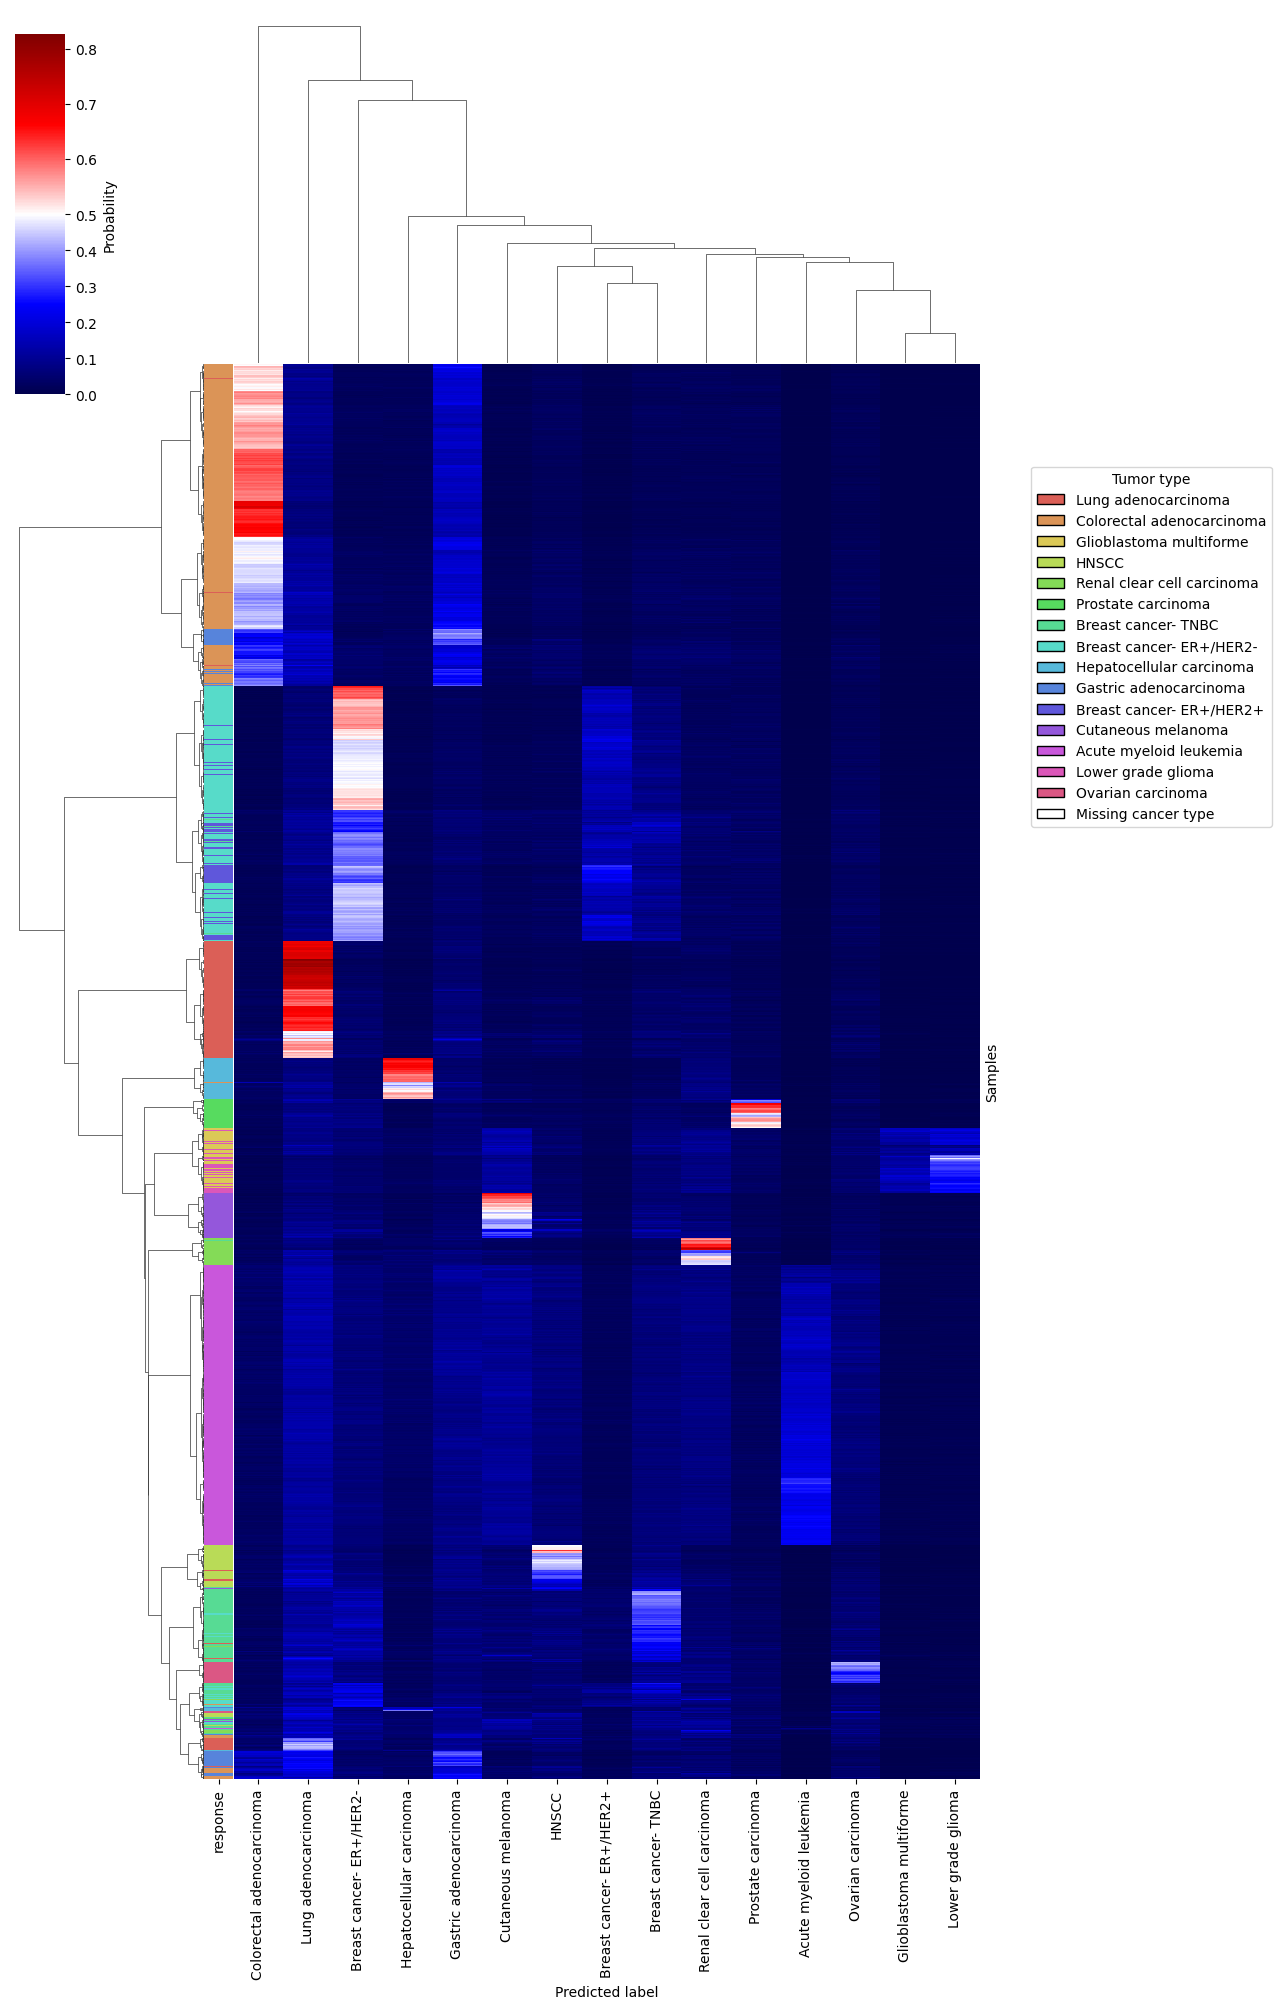

In [5]:
ypredict_probs = cforest.predict(newx=ma_data.drop(columns=["response"]), type="prob")
ypredict = cforest.predict(newx=ma_data.drop(columns=["response"]), type="response")
cforest.runID = "ma_assessment"
cforest.assess(ytrue=ma_data["response"], ypredict=ypredict, ypredict_probs=ypredict_probs, name="clustermap_ma")

Hmm that performance isn't very good.
Let's explore some more.

# Feature Importance

Feature importance may be calculated like below, but it may take a while. I shall therefore load it from a file.

In [ ]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

importr("partykit")
robjects.r.assign("best_forest", cforest.fitted_model)

varimp = pd.DataFrame(robjects.r("data.frame(varimp(best_forest, cores = 50, conditional = FALSE))"))

In [ ]:
varimp.T